In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn 
import torch.optim as optim

import copy
import tqdm

import util
import os 

In [2]:
cwd = os.getcwd()
print(cwd)

/home/linhnm/msc_code/big_data_mining/eabdt/python


In [3]:
dataset = 'mix'

training_batch_from = 0
training_batch_to = 1500
val_batch_from = 3000
val_batch_to = 3600

testing_batch_from = 0
testing_batch_to = 400

In [4]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda:0'
  print('ok')

ok


In [5]:
X_train = util.load_vector(os.path.join(cwd, '../data/vectorize/mix/training_set'), training_batch_from, training_batch_to)
y_train = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), training_batch_from, training_batch_to)

X_val = util.load_vector(os.path.join(cwd, '../data/vectorize/mix/training_set'), val_batch_from, val_batch_to)
y_val = util.load_label(os.path.join(cwd, '../data/raw/mix/training_set'), val_batch_from, val_batch_to)

X_test = util.load_vector(os.path.join(cwd, '../data/vectorize/mix/testing_set'), testing_batch_from, testing_batch_to)
y_test = util.load_label(os.path.join(cwd, '../data/raw/mix/testing_set'), testing_batch_from, testing_batch_to)

In [6]:
type(y_train)

numpy.ndarray

In [7]:
X_gpu_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_gpu_train = torch.flatten(torch.tensor(y_train).type(torch.float32)).to(device)
X_gpu_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_gpu_val = torch.flatten(torch.tensor(y_val).type(torch.float32)).to(device)
X_gpu_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_gpu_test = torch.flatten(torch.tensor(y_test).type(torch.float32)).to(device)

In [8]:
print(X_train.shape, y_train.shape)
print(X_gpu_train.is_cuda)

(1500000, 384) (1500000, 1)
True


In [9]:
epochs = 10000
trigger = 1000
early_stopping_round = 20

input_dim = 384
output_dim = 1
learning_rate = 0.01

In [10]:
class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    outputs = torch.sigmoid(self.linear(x))
    return outputs

In [11]:
model = LogisticRegression(input_dim, output_dim).to(device)

In [12]:
criterion = nn.BCELoss()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# import time
losses = []
losses_val = []
Iterations = []
best_loss = torch.tensor(np.inf).to(device)
iter = 0
early = 0
for epoch in tqdm.tqdm(range(int(epochs)),desc='Training Epochs'):
    # start = time.time()
    x = X_gpu_train
    labels = y_gpu_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_gpu_train)
    loss = criterion(torch.squeeze(outputs), labels) 

    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

    optimizer.step() # Updates weights and biases with the optimizer (SGD)

    iter+=1
    early+=1
    if iter%trigger==0:
        early+=1
        with torch.no_grad():
            # Calculating the loss and accuracy for the val dataset
            correct_val = 0
            total_val = 0
            outputs_val = torch.squeeze(model(X_gpu_val))
            loss_val = criterion(outputs_val, y_gpu_val)
            
            # predicted_val = outputs_val.round()
            total_val += y_gpu_val.size(0)
            correct_val += torch.eq(outputs_val.round(), y_gpu_val).sum()
            accuracy_val = 100 * correct_val/total_val
            losses_val.append(loss_val.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_gpu_train.size(0)
            # correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_gpu_train.detach().numpy())
            correct += torch.eq(torch.squeeze(outputs).round(), y_gpu_train).sum()
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nval - Loss: {loss_val.item()}. Accuracy: {accuracy_val}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            
            # if (early%early_stopping_round == 0) and (loss_val > torch.min(torch.tensor(losses_val[-4:-1]))):
            #     print(f'Early stopping, loss val: {loss_val}')
            #     break
            
    # end = time.time()
    # print(f'epoch: {epoch}, training time: {end - start}')

Training Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Training Epochs:  11%|█         | 1056/10000 [00:09<01:09, 128.44it/s]

Iteration: 1000. 
val - Loss: 0.3303464651107788. Accuracy: 85.96099853515625
Train -  Loss: 0.33161646127700806. Accuracy: 85.91226959228516



Training Epochs:  21%|██        | 2056/10000 [00:18<01:01, 129.15it/s]

Iteration: 2000. 
val - Loss: 0.3234359920024872. Accuracy: 86.2768325805664
Train -  Loss: 0.325481653213501. Accuracy: 86.19060516357422



Training Epochs:  31%|███       | 3056/10000 [00:27<00:53, 130.34it/s]

Iteration: 3000. 
val - Loss: 0.32167938351631165. Accuracy: 86.37616729736328
Train -  Loss: 0.32394617795944214. Accuracy: 86.267333984375



Training Epochs:  41%|████      | 4056/10000 [00:37<00:45, 129.73it/s]

Iteration: 4000. 
val - Loss: 0.321316659450531. Accuracy: 86.39633178710938
Train -  Loss: 0.3236273229122162. Accuracy: 86.28199768066406



Training Epochs:  51%|█████     | 5056/10000 [00:46<00:38, 129.02it/s]

Iteration: 5000. 
val - Loss: 0.3212760388851166. Accuracy: 86.41016387939453
Train -  Loss: 0.32358676195144653. Accuracy: 86.27973175048828



Training Epochs:  61%|██████    | 6056/10000 [00:55<00:31, 126.43it/s]

Iteration: 6000. 
val - Loss: 0.3212783932685852. Accuracy: 86.40933227539062
Train -  Loss: 0.32358431816101074. Accuracy: 86.28047180175781



Training Epochs:  71%|███████   | 7056/10000 [01:04<00:22, 128.59it/s]

Iteration: 7000. 
val - Loss: 0.3212786912918091. Accuracy: 86.40983581542969
Train -  Loss: 0.32358431816101074. Accuracy: 86.28067016601562



Training Epochs:  81%|████████  | 8056/10000 [01:13<00:15, 128.22it/s]

Iteration: 8000. 
val - Loss: 0.32127875089645386. Accuracy: 86.40999603271484
Train -  Loss: 0.32358428835868835. Accuracy: 86.2807388305664



Training Epochs:  91%|█████████ | 9056/10000 [01:22<00:07, 128.60it/s]

Iteration: 9000. 
val - Loss: 0.32127875089645386. Accuracy: 86.40999603271484
Train -  Loss: 0.32358428835868835. Accuracy: 86.2807388305664



Training Epochs: 100%|██████████| 10000/10000 [01:31<00:00, 108.74it/s]

Iteration: 10000. 
val - Loss: 0.32127875089645386. Accuracy: 86.40999603271484
Train -  Loss: 0.32358428835868835. Accuracy: 86.2807388305664



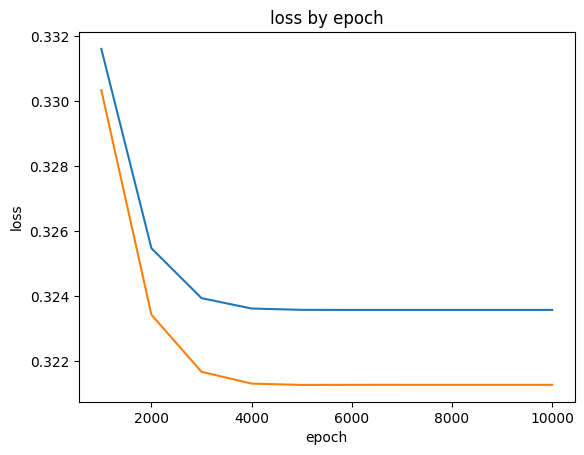

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(Iterations, losses, color='tab:blue')
ax.plot(Iterations, losses_val, color='tab:orange')


plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss by epoch')
plt.show()

In [16]:
correct_test = 0
total_test = 0
outputs_test = torch.squeeze(model(X_gpu_test))
loss_test = criterion(outputs_test, y_gpu_test)

total_test += y_gpu_test.size(0)
correct_test += torch.eq(outputs_test.round(), y_gpu_test).sum()
accuracy_test = 100 * correct_test/total_test

In [17]:
accuracy_test.item()

86.32099914550781

In [18]:
# model_path = '../model/torch_logistic_regression'
# torch.save(model.state_dict(), model_path)